# Transfer Learning

Hasta ahora, hemos entrenado modelos precisos en grandes conjuntos de datos, y también hemos descargado un modelo preentrenado que hemos utilizado sin necesidad de entrenamiento. Pero, ¿y si no podemos encontrar un modelo preentrenado que haga exactamente lo que necesitamos, y si no disponemos de un conjunto de datos lo suficientemente grande como para entrenar un modelo desde cero? En este caso, hay una técnica muy útil que podemos utilizar y que se llama [aprendizaje por transferencia](https://blogs.nvidia.com/blog/2019/02/07/what-is-transfer-learning/).

Con el aprendizaje por transferencia, tomamos un modelo preentrenado y lo volvemos a entrenar en una tarea que tiene cierto solapamiento con la tarea de entrenamiento original. Una buena analogía es la de un artista experto en un medio, como la pintura, que quiere aprender a practicar otro medio, como el dibujo a carboncillo. Podemos imaginar que las habilidades que aprendieron mientras pintaban serían muy valiosas para aprender a dibujar con carboncillo. 

Como ejemplo en aprendizaje profundo, digamos que tenemos un modelo pre-entrenado que es muy bueno reconociendo diferentes tipos de coches, y queremos entrenar un modelo para reconocer tipos de motocicletas. Muchos de los aprendizajes del modelo de coche serían probablemente muy útiles, por ejemplo la capacidad de reconocer faros y ruedas. 

El aprendizaje por transferencia es especialmente potente cuando no disponemos de un conjunto de datos amplio y variado. En este caso, un modelo entrenado desde cero probablemente memorizaría los datos de entrenamiento rápidamente, pero no sería capaz de generalizar bien a nuevos datos. Con el aprendizaje por transferencia, puede aumentar sus posibilidades de entrenar un modelo preciso.



## Objetivos

* Preparar un modelo preentrenado para el aprendizaje de transferencia
* Realizar el aprendizaje por transferencia con nuestro propio conjunto de datos en un modelo preentrenado.
* Afinar aún más el modelo para obtener mejores resultados.

## Una puerta personalizada para el perro del Presidente

En nuestro último ejercicio, utilizamos un modelo [ImageNet](http://www.image-net.org/) preentrenado para dejar entrar a todos los perros, pero mantener fuera a otros animales. En este ejercicio, queremos crear una puerta para perros que sólo deje entrar a un perro en particular. En este caso, haremos una puerta automática para un perro llamado Bo, el Primer Perro de Estados Unidos entre 2009 y 2017. Hay más fotos de Bo en la carpeta `data/presidential_doggy_door`.

<img src="./datasets/presidential_doggy_door/train/bo/bo_10.png">

El problema es que el modelo preentrenado no fue entrenado para reconocer a este perro en concreto, y sólo tenemos 30 fotos de Bo. Si intentáramos entrenar un modelo desde cero con esas 30 fotos, nos encontraríamos con un exceso de ajuste y una generalización deficiente.    

Sin embargo, si empezamos con un modelo preentrenado que es experto en la detección de perros, podemos aprovechar ese aprendizaje para obtener un conocimiento generalizado de Bo utilizando nuestro conjunto de datos más pequeño.    

Podemos utilizar el aprendizaje por transferencia para resolver este problema.

## Descargando el modelo preentrenado

Los [modelos preentrenados de ImageNet](https://keras.io/api/applications/vgg/#vgg16-function) suelen ser buenas opciones para el aprendizaje por transferencia de visión por ordenador, ya que han aprendido a clasificar varios tipos diferentes de imágenes. Al hacerlo, han aprendido a detectar muchos tipos diferentes de [características](https://developers.google.com/machine-learning/glossary#) que podrían ser valiosas en el reconocimiento de imágenes. Dado que los modelos de ImageNet han aprendido a detectar animales, incluidos los perros, es especialmente adecuada para esta tarea de aprendizaje por transferencia de detección de Bo.

Empecemos descargando el modelo preentrenado. De nuevo, está disponible directamente desde la librería Keras. Como estamos descargando, va a haber una diferencia importante. La última capa de un modelo ImageNet es una [capa densa](https://developers.google.com/machine-learning/glossary#dense-layer) de 1000 unidades, que representan las 1000 clases posibles en el conjunto de datos. En nuestro caso, queremos que haga una clasificación diferente: ¿este es Bo o no? Como queremos que la clasificación sea diferente, vamos a eliminar la última capa del modelo. Podemos hacerlo estableciendo la bandera `include_top=False` al descargar el modelo.    

Después de eliminar esta capa superior, podemos añadir nuevas capas que nos darán el tipo de clasificación que queremos:

In [1]:
from tensorflow import keras

base_model = keras.applications.VGG16( # Descargamos el modelo VGG16
    weights='imagenet',  # Cargamos los pesos pre-entrenados en ImageNet
    input_shape=(224, 224, 3), # Definimos el tamaño de la imagen de entrada y el número de canales
    include_top=False) # No incluimos la capa densa final de clasificación de 1000 clases de ImageNet

2025-03-14 14:48:32.454934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 14:48:32.641918: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 14:48:32.787943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741963712.947494    1330 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741963712.995624    1330 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 14:48:33.433846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## 'Congelar' el modelo base.    

Antes de añadir nuestras nuevas capas al [modelo pre-entrenado](https://developers.google.com/machine-learning/glossary#pre-trained-model), debemos dar un paso importante: **congelar las capas pre-entrenadas** del modelo.    
Esto significa que cuando entrenemos, no actualizaremos las capas base del modelo pre-entrenado. En su lugar, sólo actualizaremos las nuevas capas que añadamos al final para nuestra nueva clasificación. Congelamos las capas iniciales porque queremos conservar el aprendizaje obtenido del entrenamiento en el conjunto de datos ImageNet.    
Si se descongelaran en esta fase, probablemente destruiríamos esta valiosa información.    

Habrá una opción para descongelar y entrenar estas capas más tarde, en un proceso llamado **ajuste fino (Fine Tunning)**.

'Congelar' las capas base es tan sencillo como establecer la opción entrenable del modelo en `False`.

In [3]:
base_model.trainable = False

## Añadiendo nuevas capas

Ahora podemos añadir las nuevas capas entrenables al modelo preentrenado. Tomarán las características de las capas preentrenadas y las convertirán en predicciones sobre el nuevo conjunto de datos. 

Añadiremos dos capas al modelo:
- La primera será una [capa de agrupación (pooling)](https://developers.google.com/machine-learning/glossary#convolutional_layer). Más info de las capas de pooling en las CNN en [esta entrada de blog](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/#:~:text=A%20pooling%20layer%20is%20a,Convolutional%20Layer)). 
- A continuación, tenemos que añadir nuestra capa final, que clasificará Bo o no Bo. Será una capa densamente conectada con una salida.

In [4]:
# Capa de entrada del modelo, con el tamaño de la imagen de entrada y el número de canales.
# En este caso, la imagen de entrada es de 224x224 píxeles y tiene 3 canales (RGB) y el tamaño de lote es 32 (por defecto)
inputs = keras.Input(shape=(224, 224, 3)) # Tensor de entrada de 4D

# De forma separada se establece el entrenamiento en Falso del modelo base (opción training=False)
x = base_model(inputs, training=False)

# Capa de Global Average Pooling para reducir la dimensionalidad de la salida de la red de base. 
# En lugar de tener un tensor de 4D, se tiene un tensor de 2D
x = keras.layers.GlobalAveragePooling2D()(x) 

# Capa densa con una sola unidad (clasificación binaria)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

Si se echa un vistazo al modelo, ahora que hemos combinado el modelo preentrenado con las nuevas capas, tenemos la estructura que se ofrece en el esquema siguiente:

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Keras nos ofrece un resumen interesante, ya que muestra el modelo pre-entrenado vgg16 como una unidad, en lugar de mostrar todas las capas internas.     

También vale la pena señalar que tenemos muchos parámetros no entrenables ya que hemos congelado el modelo pre-entrenado. 

## Compilación del modelo

Como en los casos anteriores, se debe compilar el modelo con opciones de función de pérdidas y métricas. Aquí tenemos que tomar algunas decisiones diferentes.    

En los casos anteriores teníamos muchas categorías en nuestro problema de clasificación. Como resultado, elegimos la `entropía cruzada categórica (categoricalcrossentropy)` para el cálculo de nuestra pérdida. En este caso sólo tenemos un problema de clasificación binaria (Bo o no Bo), por lo que utilizaremos [crossentropy binaria](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy). También utilizaremos la `exactitud binaria (BinaryAccuracy)` en lugar de la `accuracy` tradicional.

Al establecer `from_logits=True` informamos a la [función de pérdida](https://gombru.github.io/2018/05/23/cross_entropy_loss/) de que los valores de salida no están normalizados (por ejemplo, con softmax).

In [6]:
# Dado que el problema es de clasificación binaria, se utiliza la función de pérdida BinaryCrossentropy y la métrica BinaryAccuracy
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

## Data Augmentation

Ahora que estamos tratando con un conjunto de datos muy pequeño, es especialmente importante que aumentemos nuestros datos. Como antes, haremos pequeñas modificaciones en las imágenes existentes, lo que permitirá al modelo ver una mayor variedad de imágenes de las que aprender. Esto le ayudará a aprender a reconocer nuevas imágenes de Bo en lugar de limitarse a memorizar las imágenes con las que se entrena.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creación de un generador de datos para el conjunto de entrenamiento y validación
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # Centramos los datos en cero
    rotation_range=10,  # aleatoriamente rotamos la imagen en el rango (grados, 0 to 180)
    zoom_range=0.1,  # aleatoriamente aplicamos zoom a la imagen
    width_shift_range=0.1,  # aleatoriamente desplazamos horizontalmente la imagen (fracción del ancho total)
    height_shift_range=0.1,  # aleatoriamente desplazamos verticalmente la imagen (fracción de la altura total)
    horizontal_flip=True,  # aleatoriamente volteamos horizontalmente la imagen
    vertical_flip=False, # no volteamos verticalmente la imagen
)  # No esperamos que Bo esté al revés, así que no lo voltearemos verticalmente.

# No es necesario aumentar los datos de validación, pero sí centrarlos en cero
datagen_valid = ImageDataGenerator(samplewise_center=True)

NOTA:

El parámetro `samplewise_center=True` en el `ImageDataGenerator` de Keras realiza una normalización específica para cada imagen individual del conjunto de datos. Veamos en detalle qué hace:   

*Propósito del centrado por muestra (samplewise_center)*

- Normalización por imagen: Para cada imagen individual, calcula su valor medio de píxeles y resta este valor de cada píxel en esa misma imagen.
- Efecto técnico: Desplaza la distribución de valores de píxeles de cada imagen para que tenga una media de cero.   

Ventajas:

1. Reduce el impacto de diferencias en la iluminación entre imágenes
2. Ayuda a que el modelo se centre en las características estructurales en lugar de en valores absolutos de intensidad
3. Mejora la estabilidad del entrenamiento y puede acelerar la convergencia

*Ejemplo numérico*   

Sobre una imagen muy simplificada de 2x2 píxeles con estos valores:    

 [[100, 120],   
 [140, 160]]   
 
El valor medio de esta imagen es: (100+120+140+160)/4 = 130   

Después de aplicar `samplewise_center=True`, cada píxel se modifica restándole este valor medio:    

[[-30, -10],    
 [10, 30]]   
 
Ahora la media de los valores es 0, lo que permite que el modelo se concentre en las diferencias relativas entre píxeles en lugar de sus valores absolutos.
Esta técnica es especialmente útil cuando las imágenes del conjunto de datos tienen diferentes condiciones de iluminación o contraste.

## Cargando los datos

Para este ejercicio, vamos a cargar imágenes directamente desde carpetas utilizando la función [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) de Keras. Hemos configurado nuestros directorios para facilitar el proceso, ya que nuestras etiquetas se deducen de los nombres de las carpetas. En el directorio `datasets/presidential_doggy_door`, tenemos los directorios de entrenamiento y validación, cada uno con carpetas para imágenes de Bo y no Bo. En los directorios not_bo, tenemos imágenes de otros perros y gatos, para enseñar a nuestro modelo a mantener alejadas a otras mascotas. Siéntase libre de explorar las imágenes para tener una idea de nuestro conjunto de datos.

Se debe tener en cuenta que [flow_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) también nos permitirá dimensionar nuestras imágenes para que coincidan con el modelo: 244x244 píxeles con 3 canales.

In [ ]:
# Se cargan las imágenes de entrenamiento desde el directorio y se redimensionan a 224x224 píxeles
train_it = datagen_train.flow_from_directory(
    "datasets/presidential_doggy_door/train/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=8,
)

# Se cargan las imágenes de validación desde el directorio y se redimensionan a 224x224 píxeles
valid_it = datagen_valid.flow_from_directory(
    "datasets/presidential_doggy_door/valid/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=8,
)

Found 139 images belonging to 2 classes.


Found 30 images belonging to 2 classes.


## Entrenamiento del modelo

Es hora de entrenar nuestro modelo y ver cómo funciona. Recordemos que cuando se utiliza un generador de datos, tenemos que establecer explícitamente el número de `steps_per_epoch`:

In [10]:
# El parametro 'steps_per_epoch' es el número de lotes de entrenamiento que se procesarán en una época.
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - binary_accuracy: 0.7699 - loss: 0.7560 - val_binary_accuracy: 0.8667 - val_loss: 0.7150
Epoch 2/20
 6/12 ━━━━━━━━━━━━━━━━━━━━ 4s 670ms/step - binary_accuracy: 0.9553 - loss: 0.3212

/usr/local/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 587ms/step - binary_accuracy: 0.9428 - loss: 0.3576 - val_binary_accuracy: 0.8667 - val_loss: 0.4318
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - binary_accuracy: 0.8985 - loss: 0.1843 - val_binary_accuracy: 0.9667 - val_loss: 0.3402
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 681ms/step - binary_accuracy: 0.9797 - loss: 0.0346 - val_binary_accuracy: 0.9667 - val_loss: 0.3750
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - binary_accuracy: 0.9342 - loss: 0.1329 - val_binary_accuracy: 0.9667 - val_loss: 0.3281
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 688ms/step - binary_accuracy: 0.9641 - loss: 0.0276 - val_binary_accuracy: 0.9667 - val_loss: 0.3346
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - binary_accuracy: 1.0000 - loss: 0.0213 - val_binary_accuracy: 0.9667 - val_loss: 0.3165
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 674ms/step - binary_accuracy: 0.9641 - loss: 0.0625 - val_binary_accuracy: 0.9667 - val_loss: 0.2362
Epoch 9/20
12/12 ━━━━━━

## Resultados

Tanto la precisión de entrenamiento como la de validación deberían ser bastante altas. Es un resultado impresionante. Hemos podido entrenarnos con un conjunto de datos pequeño, pero gracias a los conocimientos transferidos del modelo ImageNet, ha sido capaz de alcanzar una gran precisión y generalizar bien. Esto significa que sabe distinguir muy bien entre Bo y las mascotas que no son Bo.

Si se ha observado alguna fluctuación en la precisión de la validación, tampoco pasa nada. Se aplicará una técnica para mejorar nuestro modelo en la siguiente sección.

## Realizando 'Fine-Tuning' sobre el modelo

Ahora que las nuevas capas del modelo están entrenadas, tenemos la opción de aplicar un último truco para mejorar el modelo, llamado [ajuste fino](https://developers.google.com/machine-learning/glossary#f). Para ello, descongelamos todo el modelo y lo entrenamos de nuevo con una [tasa de aprendizaje] muy pequeña(https://developers.google.com/machine-learning/glossary#learning-rate). Esto hará que las capas preentrenadas de base den pasos muy pequeños y se ajusten ligeramente, mejorando el modelo en una pequeña cantidad.  

Tengamos en cuenta que es importante realizar este paso sólo después de que el modelo con capas congeladas haya sido completamente entrenado.    
Las capas no entrenadas de agrupación y clasificación que añadimos antes al modelo se inicializaron aleatoriamente. Esto significa que necesitaban actualizarse bastante para clasificar correctamente las imágenes.    

Mediante el proceso de [retropropagación](https://developers.google.com/machine-learning/glossary#backpropagation), las grandes actualizaciones iniciales en las últimas capas habrían causado también actualizaciones potencialmente grandes en las capas preentrenadas. Estas actualizaciones habrían destruido esas importantes características preentrenadas.    

Sin embargo, ahora que esas últimas capas están entrenadas y han convergido, cualquier actualización del modelo en su conjunto será mucho menor (especialmente con una tasa de aprendizaje muy pequeña) y no destruirá las características de las capas anteriores.

Intentemos descongelar las capas preentrenadas y luego afinar el modelo:

In [11]:
# Descongelamos el modelo base
base_model.trainable = True

# Es importante recompilar el modelo después de hacer cualquier cambio
# al atributo `trainable` de cualquier capa interna, para que sus cambios
# se tengan en cuenta en el proceso de entrenamiento.
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [12]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - binary_accuracy: 1.0000 - loss: 0.0202 - val_binary_accuracy: 1.0000 - val_loss: 0.0248
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - binary_accuracy: 1.0000 - loss: 7.2407e-04 - val_binary_accuracy: 1.0000 - val_loss: 0.0429
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - binary_accuracy: 1.0000 - loss: 0.0014 - val_binary_accuracy: 1.0000 - val_loss: 0.0436
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - binary_accuracy: 1.0000 - loss: 9.6399e-04 - val_binary_accuracy: 0.9333 - val_loss: 0.0957
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - binary_accuracy: 1.0000 - loss: 5.3663e-06 - val_binary_accuracy: 0.9333 - val_loss: 0.0982
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - binary_accuracy: 1.0000 - loss: 8.3984e-06 - val_binary_accuracy: 0.9333 - val_loss: 0.0991
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - binary_accuracy: 1.0000 - loss: 3.3709e-06 - val_binary_accuracy: 0.9333 - val_loss: 0.0969


## Analizando las predicciones

Ahora que tenemos un modelo bien entrenado, ¡es hora de crear nuestra puerta para perros para Bo!    

Podemos empezar observando las predicciones del modelo. Vamos a preprocesar la imagen de la misma manera que lo hicimos para nuestra última puerta del perrito.

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

Probémoslo con un par de imágenes para ver las predicciones:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


array([[-18.359278]], dtype=float32)

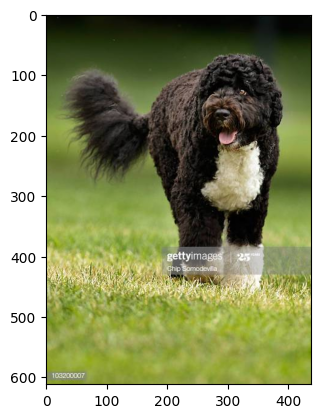

In [16]:
make_predictions('/workspaces/DATASCIENCE/CEIABD_REPO/CEIABD_MODULOS_IA/SISTEMAS DE APRENDIZAJE AUTOMATICO/NOTEBOOKS DEL AULA/Redes Neuronales/datasets/presidential_doggy_door/valid/bo/bo_20.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


array([[25.935917]], dtype=float32)

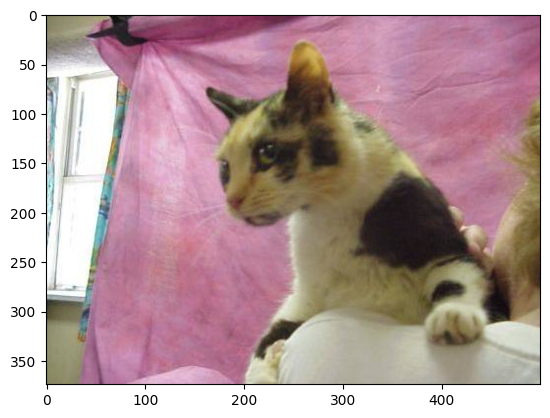

In [17]:
make_predictions('/workspaces/DATASCIENCE/CEIABD_REPO/CEIABD_MODULOS_IA/SISTEMAS DE APRENDIZAJE AUTOMATICO/NOTEBOOKS DEL AULA/Redes Neuronales/datasets/presidential_doggy_door/valid/not_bo/121.png')

Parece que una predicción con número negativo indica que se trata de Bo y una predicción de número positivo significa que es otra cosa.    

Podemos utilizar esta información para que la puerta de nuestro perro sólo deje entrar a Bo. 

## Ejercicio: La Puerta para Bo!

Rellena el siguiente código para implementar la puerta para Bo:

In [ ]:
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if FIXME:
        print("Es Bo! Que pase!")
    else:
        print("No es Bo! Fuera!")

## Solución

Click sobre los '...' para desplegar la solución.

In [18]:
# SOLUCIÓN
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("Es Bo! Que pase!")
    else:
        print("No es Bo! Fuera!")

Probemos!!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
No es Bo! Fuera!


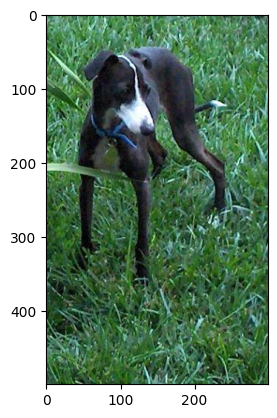

In [19]:
presidential_doggy_door('/workspaces/DATASCIENCE/CEIABD_REPO/CEIABD_MODULOS_IA/SISTEMAS DE APRENDIZAJE AUTOMATICO/NOTEBOOKS DEL AULA/Redes Neuronales/datasets/presidential_doggy_door/valid/not_bo/131.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Es Bo! Que pase!


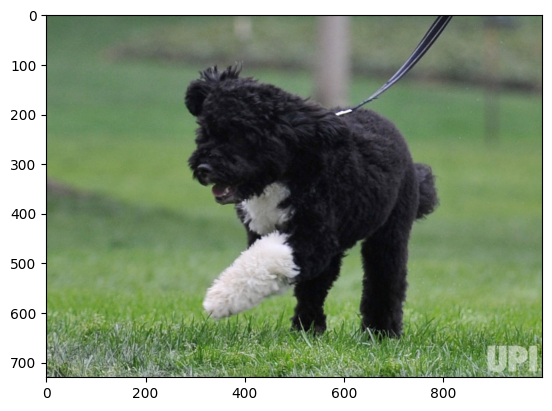

In [20]:
presidential_doggy_door('/workspaces/DATASCIENCE/CEIABD_REPO/CEIABD_MODULOS_IA/SISTEMAS DE APRENDIZAJE AUTOMATICO/NOTEBOOKS DEL AULA/Redes Neuronales/datasets/presidential_doggy_door/valid/bo/bo_29.png')